**Informe N°2 Astronomía Experimental:  Cinemática Galáctica códigos** \
Profesores: Leonardo Bronfman A. \
Auxiliar: Lukas Philippi Y. \
Estudiante: Antonella Zavala Cerda 

**Cinemática galáctica**

In [78]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits as F
from scipy import stats
from astropy.stats import sigma_clip

In [81]:
# visualizar path del archivo 
import os 
print(os.getcwd())


/Users/antozzavalac/Jupyter /Astro Experimental 1/CinematicaG


**Detalles iniciales**

In [82]:
# Importación archivo 
path_archivo = "/Users/antozzavalac/Jupyter /Astro Experimental 1/CinematicaG/Cubo_de_Datos.fits"

# Obtenemos data del cubo
cubo = F.open(path_archivo)

# Print header, para conocer la info del cubo
cubo[0].header



SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                   16  / Bits per pixel                                
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                  306  / Number pixels on axis 1                       
NAXIS2  =                  385  / Number pixels on axis 2                       
NAXIS3  =                   33  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
CDELT2  =         1.250000E-

In [83]:
# Se guarda header:
header = cubo[0].header

# Se guarda data:
data = cubo[0].data

# orden ejes 
data.shape


(33, 385, 306)

Notamos, a pesar de lo que se ve en el header, tras visualizar data.shape:
- Coordenada 1: Latitud Galáctica (33 pixels)(**b**)
- Coordenada 2: Longitud Galáctica (385 pixels)(**l**)
- Coordenada 3:  velocidad LSR(306 pixels)(**v**) 

**NOTA:** Se utiliza código expuesto en auxiliar para la filtración del espectro de velocidades.

In [84]:
# definimos función para extraer ejes del cubo con las unidades correspondientes

def cube_axis(hdr):
    axis = hdr['NAXIS']
    axis_dict = {}
    for i in range(axis):
        min_val_i = float(hdr['CRVAL' + str(i + 1)])
        delt_i = float(hdr['CDELT' + str(i + 1)])
        Naxis_i = int(hdr['NAXIS' + str(i + 1)])
        axis_i = np.linspace(min_val_i, min_val_i + (Naxis_i - 1)*delt_i, Naxis_i)
        axis_dict[hdr['CTYPE' + str(i + 1)]] = axis_i
    return axis_dict

axis_dict = cube_axis(header)


# Extraemos los vectores de los ejes

velocidad = axis_dict['VELO-LSR']
longitud = axis_dict['GLON-FLT']
latitud = axis_dict['GLAT-FLT']

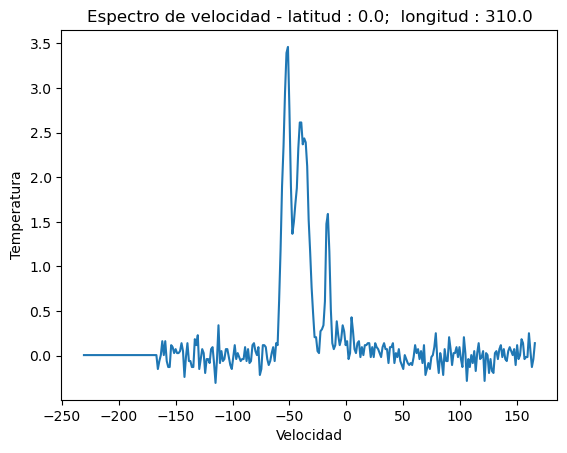

In [85]:
# eje 1: latitud (data[0]) (b)
# eje 2: longitud(data[0][0]) (l)
# eje 3: velocidad (data[0][0][0])

# Funcion para encontrar un indice en un arreglo del valor mas cercano a un valor dado. Solo funciona si el array esta ordenado
def nearest_ind(arr, val):
    ind = 0
    for i in range(len(arr)):
        if arr[i] <= val:
            ind = i
        else:
            return ind
    return ind

# Espectro de velocidad

lat_2 = 0.
lat_2_i = nearest_ind(latitud, lat_2)
lat_2 = latitud[lat_2_i]

lon_2 = 310.
lon_2_i = nearest_ind(longitud, lon_2)
lon_2 = longitud[lon_2_i]

info = 'latitud : ' + str(np.round(lat_2, 4)) + ';  longitud : ' + str(np.round(lon_2, 4))

T_spect = data[lat_2_i][lon_2_i][:]

#ahora graficamos el espectro
plt.plot(velocidad, T_spect)
plt.xlabel('Velocidad')
plt.ylabel('Temperatura')
plt.title('Espectro de velocidad - ' + info)
plt.show()

**FILTRACIÓN DEL ESPECTRO**\
Se utiliza $\sigma$ como parámetro para extraer información relacionada a observaciones y no ruido.
* Se considera observaciones a $T \geq 5 \cdot \sigma_{T}$

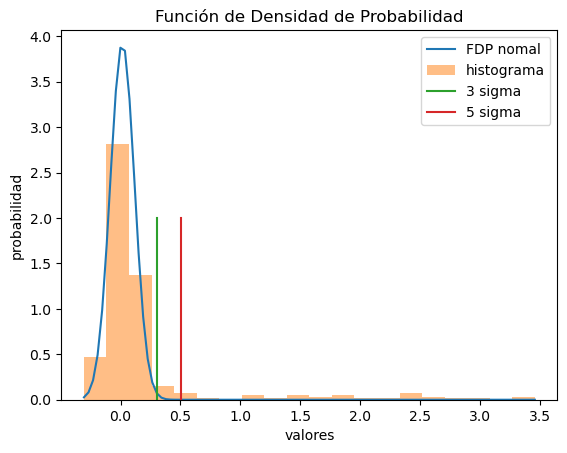

In [86]:
# Primero revisamos la distribucion de probabilidad de temperaturas

r = sigma_clip(T_spect, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
mean_spect = np.mean(r) # promedio
std_spect = np.sqrt(np.mean(r**2)) # desviacion estandar

x_t = np.linspace(min(T_spect), max(T_spect), 100) # vector con rango de T_spect

FDP_normal = stats.norm(mean_spect, std_spect).pdf(x_t) # distribucion de probabilidades normal

plt.plot(x_t, FDP_normal, label='FDP nomal') # graficamos la distribucion de probabilidades
plt.hist(T_spect, density=True, alpha=0.5, bins = 20, label = 'histograma') # graficamos un histograma
plt.plot(np.array([3*std_spect, 3*std_spect]), np.array([0, 2]), label = '3 sigma')
plt.plot(np.array([5*std_spect, 5*std_spect]), np.array([0, 2]), label = '5 sigma')

plt.title('Función de Densidad de Probabilidad')
plt.ylabel('probabilidad')
plt.xlabel('valores')
plt.legend(loc = 'upper right')
plt.show()

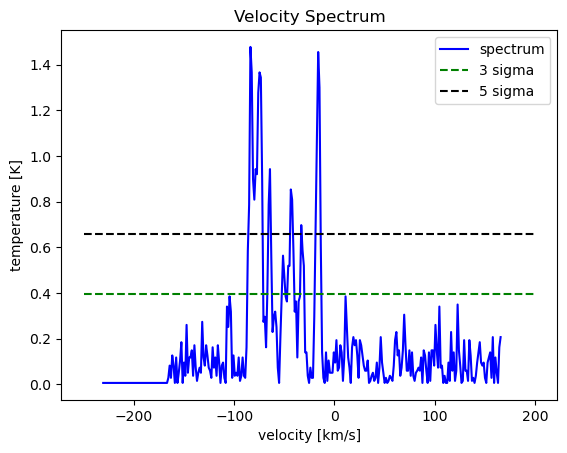

In [87]:
T_spc = data[14,200,:] # espectro de velocidad (temperatura)

r = sigma_clip(T_spc, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
sigma_T = np.sqrt(np.mean(r**2)) # calculamos RMS del subconjunto anterior

plt.plot(velocidad, abs(T_spc), color='b', label='spectrum')
plt.plot([-250,200],[3*sigma_T,3*sigma_T], 'g--', label='3 sigma')
plt.plot([-250,200],[5*sigma_T,5*sigma_T], 'k--', label='5 sigma')
plt.xlabel('velocity [km/s]')
plt.ylabel('temperature [K]')
plt.legend()
plt.title('Velocity Spectrum')
plt.show()

**Ahora empieza el código personal**

**CURVA DE ROTACIÓN**

Para encontrar la velocidad máxima (**velocidad terminal**) para cada longitud galáctica, calcular el radio y velocidad de rotación, y finalmente obtener la curva de rotación de la galaxia, se siguen los pasos:
1. Se determina velocidad máxima ($V_{LSR,max}$) para cada longitud galática.
2. Se definen las constantes galácticas.
3. Se calcula radio galactocéntrico ($R$) y velocidad de rotación ($V_{rot}$).
4. Finalmente, se grafica curva de rotación.

In [88]:
#1: Se determina velocidad máxima para cada longitud galáctica
# Se proyecta intensidad en plano l-v

# Proyección:
# probamos con mediana:
mapa_lv = np.median(data, axis = 0) # mediana de los datos
mapa_lv.shape

# Se busca V_max para cada longitud
v_max_l = [] # V_max para cada longitud

for espectro_l in mapa_lv:
    #pixel con intensidad max en espectro de velocidad
    idx_max_intensidad =np.argmax(espectro_l)
    

    # v max se encuentra en borde del espectro
    # Encontrar lim velocidad (V_max) donde intensidad decae a 0
    # Creación de máscara
    umbral = 5 * sigma_T
    velocidades_detectadas = velocidad[espectro_l > umbral]
   
    if len(velocidades_detectadas) > 0:
        # Consideramos IV cuadrante
        v_max = np.min(velocidades_detectadas)
        
    else:
        v_max = np.nan # no detecta emisión

    v_max_l.append(v_max)
v_max_l = np.array(v_max_l)
print(v_max_l)


[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan -39.6397 -39.6397 -39.6397      nan
      nan  -4.5289      nan      nan      nan      nan -31.8373      nan
      nan -37.0389 -34.4381 -35.7385 -37.0389 -37.0389 -35.7385 -34.4381
 -34.4381 -31.8373 -31.8373 -31.8373  -3.2285 -26.6357 -27.9361 -27.9361
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan -26.6357 -26.6357 -26.6357 -47.4421 -39.6397
 -40.9401 -52.6437      nan -51.3433 -51.3433 -40.9401 -40.9401 -47.4421
 -48.7425 -51.3433 -55.2445 -56.5449 -53.9441 -56.5449 -56.5449 -57.8453
 -59.1457 -57.8453 -55.2445 -53.9441 -53.9441 -53.9441 -52.6437 -53.9441
 -53.9441 -53.9441 -53.9441 -52.6437 -51.3433 -50.0429 -52.6437 -52.6437
 -51.3433 -51.3433 -51.3433 -52.6437 -53.9441 -51.3

In [90]:
# Datos (ctes a utilizar)
R0 = 8.5 # en kpc, radio del Sol hasta Centro Galáctico
V0 = 220 # km/s, velocidad de rotación del Sol
omega0 = V0/R0
l_rad = np.deg2rad(longitud)
#print(l_rad)

In [91]:
# Se calcula radio (R)
# R = R0 * sen(l)
R = R0 * np.sin(l_rad) * -1

print(R)

[7.36121593 7.35192636 7.34260179 7.33324228 7.32384786 7.31441859
 7.3049545  7.29545564 7.28592206 7.27635379 7.2667509  7.25711342
 7.2474414  7.23773488 7.22799391 7.21821854 7.20840882 7.19856478
 7.18868648 7.17877397 7.16882729 7.15884649 7.14883161 7.13878271
 7.12869983 7.11858302 7.10843232 7.0982478  7.08802949 7.07777744
 7.0674917  7.05717233 7.04681937 7.03643286 7.02601287 7.01555943
 7.0050726  6.99455243 6.98399897 6.97341227 6.96279238 6.95213934
 6.94145322 6.93073406 6.91998191 6.90919682 6.89837885 6.88752804
 6.87664445 6.86572813 6.85477914 6.84379751 6.83278332 6.8217366
 6.81065741 6.7995458  6.78840184 6.77722556 6.76601702 6.75477628
 6.74350339 6.73219841 6.72086138 6.70949236 6.69809141 6.68665857
 6.67519391 6.66369748 6.65216933 6.64060952 6.62901811 6.61739514
 6.60574067 6.59405477 6.58233747 6.57058885 6.55880896 6.54699785
 6.53515557 6.52328219 6.51137777 6.49944235 6.48747599 6.47547876
 6.46345071 6.45139189 6.43930237 6.4271822  6.41503143 6.40285

In [92]:
# Calculamos velocidad de rotación:
#V_rot = (v_max_l * np.abs(np.sin(l_rad))/np.sin(l_rad)) + V0 * np.abs(np.sin(l_rad))
V_rot = (np.abs((v_max_l)) + V0 * np.abs(np.sin(l_rad)))
print(V_rot)

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan 227.22053616 226.96930864 226.7171895
          nan          nan 190.84469436          nan          nan
          nan          nan 216.86588285          nan          nan
 221.28457809 218.42105429 219.45785479 220.49378085 220.22843374
 218.66181471 217.09432502 216.82636596 213.9567388  213.68704481
 213.41648528 184.5362615  207.67117475 208.69842635 208.42441758
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan 199.1078701  198.80949451 198.51029943
 219.01668628 210.9134565  211.91221152 223.31335277          nan
 221.405599

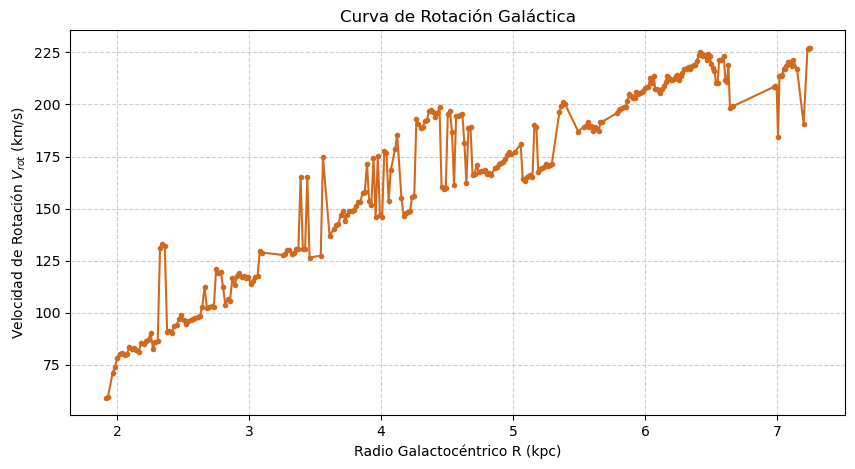

In [93]:
# Graficar Curva de rotación:
# Máscara para valores NaN o infinitos 
mascara = np.isfinite(V_rot) & np.isfinite(R)


plt.figure(figsize=(10, 5))
plt.plot(R[mascara], V_rot[mascara], 'o-', markersize= 3, color = 'chocolate')
plt.xlabel('Radio Galactocéntrico R (kpc)')
plt.ylabel('Velocidad de Rotación $V_{rot}$ (km/s)')
plt.title('Curva de Rotación Galáctica')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [94]:
# Se grafica para ω(R) vs R:
# A partir de la velocidad de rotación: 
# ω(R) = v_rot / R0 * sin(l) + ω0
V_rot_rn = ((v_max_l) + V0 * np.sin(l_rad))
omega = (( V_rot_rn / (R0 * np.sin(l_rad))) + omega0)
print(omega)

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 57.23418095 57.24151605 57.248897           nan         nan 52.39384518
         nan         nan         nan         nan 56.21820286         nan
         nan 56.96783408 56.60938871 56.79953997 56.99026259 56.99783172
 56.82145041 56.64457821 56.65174757 56.28934225 56.29605255 56.30280442
 52.22558619 55.57276941 55.76472079 55.77079342         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan 55.76184112 55.76876812 55.77573829 58.92143698 57.75493303
 57.96236062 59.74821555         nan 59.57881526 59.59284973 58.01796897
 58.02930043 59.03744046 59.2504488  59.66435285 60

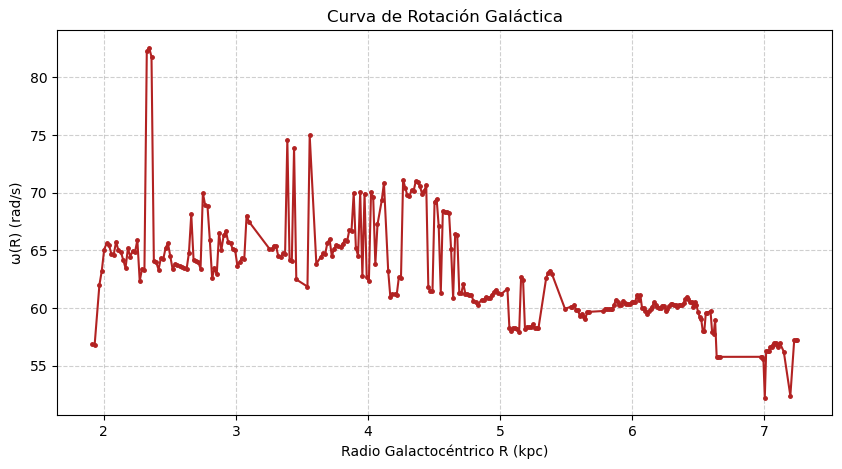

In [95]:
# Se grafica: 

# Máscara para valores NaN o infinitos 
mascara = np.isfinite(V_rot) & np.isfinite(R) & np.isfinite(omega)


plt.figure(figsize=(10, 5))
plt.plot(R[mascara], omega[mascara], 'o-', markersize= 2.5, color = 'firebrick')
plt.xlabel('Radio Galactocéntrico R (kpc)')
plt.ylabel('ω(R) (rad/s)')
plt.title('Curva de Rotación Galáctica')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

**CORRUGACIÓN DEL PLANO**

In [96]:
# Se calcular mapa de Intensidad Integrada 
# Se suman los datos a lo largo del eje de velocidad
integra_intensidad = np.sum(data, axis=2)

# Se busca peak en latitud  para cada longitud
b_peak_indices = np.argmax(integra_intensidad, axis=0)
# Se convierte a grados
b_peak_grados = latitud[b_peak_indices]


# Cálculo de R y z (para el 4to Cuadrante)
# A radianes
l_rad = np.deg2rad(longitud)
b_rad = np.deg2rad(b_peak_grados)

# Filtración para el 4to cuadrante (sin(l) < 0)
mask_q4 = np.sin(l_rad) < 0
l_rad_q4 = l_rad[mask_q4]
b_rad_q4 = b_rad[mask_q4]


In [97]:
# Fórmulas para corrugación:

R_corrug = -R0 * np.sin(l_rad_q4) # R = R0 * |sin(l)|
D_tangente = R0 * np.cos(l_rad_q4) # Distancia = R0 * cos(l)
z_corrug = D_tangente * np.tan(b_rad_q4) # z = D * tan(b)

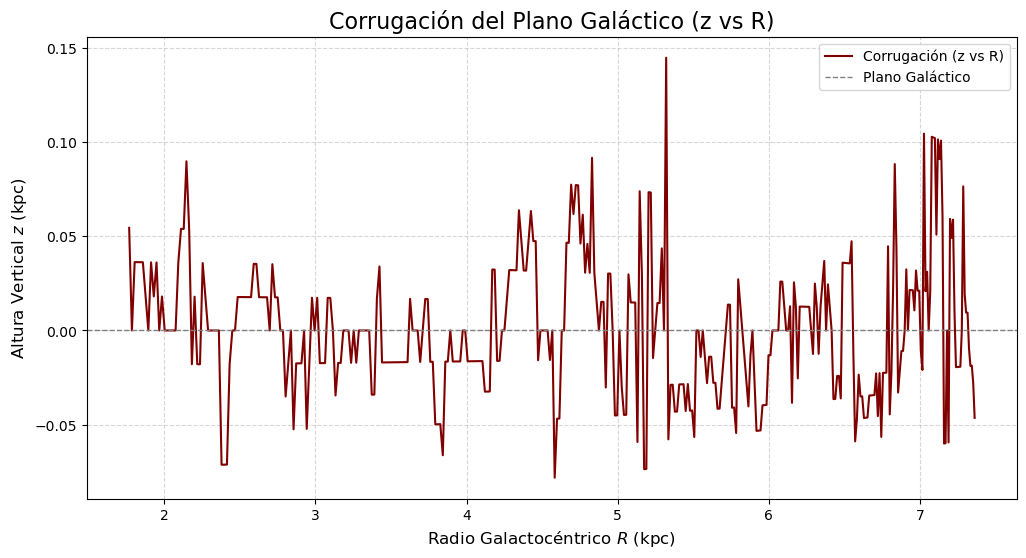

In [98]:
# Gráfico la Corrugación 
# z vs Radios


# Orden de los datos por R 
# índices que ordenan el arreglo R
indices_ordenados = np.argsort(R_corrug)
# Reordenamiento R y z usando índices
R_ordenado = R_corrug[indices_ordenados]
z_ordenado = z_corrug[indices_ordenados]

# Gráfico z vs R (gráfico de línea)
plt.figure(figsize=(12, 6))
plt.plot(R_ordenado, z_ordenado, '-', color='maroon', label='Corrugación (z vs R)')

plt.axhline(0, color = 'gray', linestyle='--', linewidth=1, label='Plano Galáctico') # línea en z = 0 como referencia
plt.title('Corrugación del Plano Galáctico (z vs R)', fontsize=16)
plt.xlabel('Radio Galactocéntrico $R$ (kpc)', fontsize=12)
plt.ylabel('Altura Vertical $z$ (kpc)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**AJUSTES DE MODELO DE MASA**

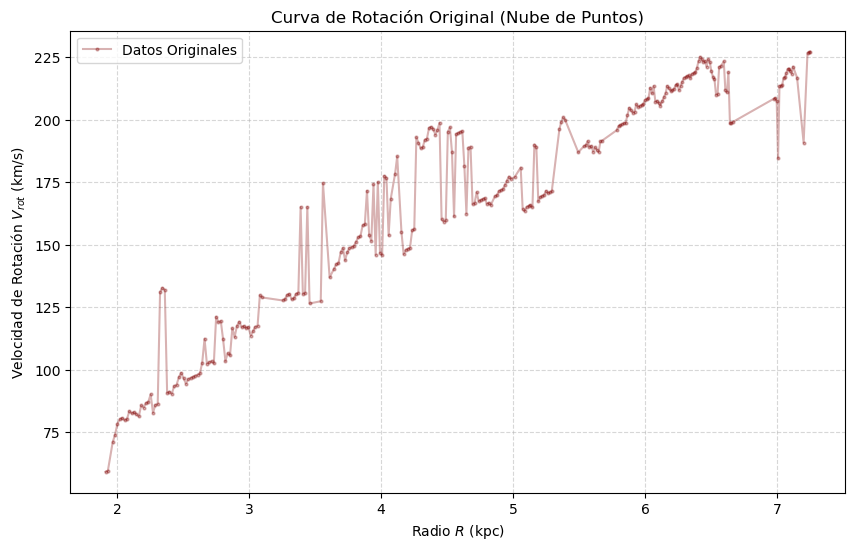

Estimaciones iniciales:
Masa puntual: p0 = [2.96e+10]
Disco uniforme: p0 = [4.41e+08]
Esfera uniforme: p0 = [7.15e+07]
Modelos combinados: p0 = [2.96e+09, 7.15e+07]


In [116]:
# Se preparación los datos (sin bin)

# Creación una máscara para filtrar NaNs o Infs que puedan existir
mascara = np.isfinite(R) & np.isfinite(V_rot) & (R > 0)
R_datos = R[mascara]
V_datos = V_rot[mascara]

# Gráfico de datos originales
plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color= 'maroon', alpha=0.3, label='Datos Originales')
plt.title('Curva de Rotación Original (Nube de Puntos)')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad de Rotación $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# función par estimar parámetros iniciales 
# (aquí se ocupo un poquito de ayuda)
def estimar_p0(R_datos, V_datos):
    # Velocidad típica
    V_typical = np.mean(V_datos)
    
    # Radio típico  
    R_typical = np.mean(R_datos)
    
    # Estimación para masa puntual: M = V^2 * R / G
    M0_est = (V_typical**2 * R_typical) / G
    
    # Estimación para disco: S = V^2 / (pi * G * R)
    S_est = V_typical**2 / (np.pi * G * R_typical)
    
    # Estimación para esfera: ρ = 3 * V^2 / (4 * pi * G * R^2)
    rho_est = 3 * V_typical**2 / (4 * np.pi * G * R_typical**2)
    
    print(f"Estimaciones iniciales:")
    print(f"Masa puntual: p0 = [{M0_est:.2e}]")
    print(f"Disco uniforme: p0 = [{S_est:.2e}]") 
    print(f"Esfera uniforme: p0 = [{rho_est:.2e}]")
    print(f"Modelos combinados: p0 = [{M0_est/10:.2e}, {rho_est:.2e}]")
    
    return M0_est, S_est, rho_est

# Uso de la función
M0_est, S_est, rho_est = estimar_p0(R_datos, V_datos)


R_suave = np.linspace(R_datos.min(), R_datos.max(), 200)

In [117]:
# Definimos cte
# Constante gravitacional (kpc, Msol, km/s)
G = 4.302e-6  


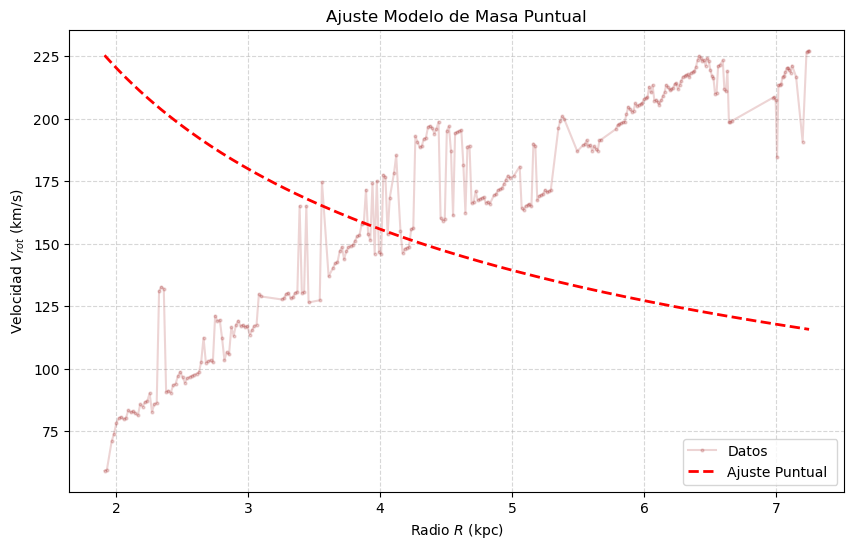

In [118]:
# Gráfico modelo masa puntual
def V_puntual(R_kpc, M0):
   
    return np.sqrt(G * M0 / R_kpc)

# Gráfico
popt_p, _ = curve_fit(V_puntual, R_datos, V_datos, p0=[1e10])
V_fit_p = V_puntual(R_suave, *popt_p)
M_fit_p = popt_p[0]

plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color='brown', alpha=0.2, label='Datos')
plt.plot(R_suave, V_fit_p, 'r--', linewidth=2, label=f'Ajuste Puntual ')
plt.title('Ajuste Modelo de Masa Puntual')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

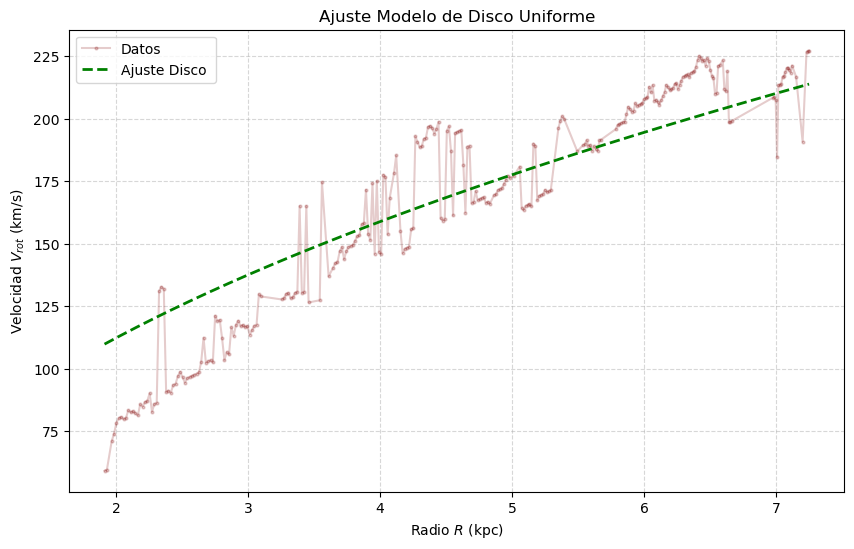

In [119]:
# Gráfico modelo disco uniforme
def V_disco_uniforme(R_kpc, S):
    
    M = np.pi * R_kpc**2 * S  # Masa dentro de radio R
    return np.sqrt(G * M / R_kpc)

# Gráfico
popt_d, _ = curve_fit(V_disco_uniforme, R_datos, V_datos, p0=[1e8])
V_fit_d = V_disco_uniforme(R_suave, *popt_d)
S_fit_d = popt_d[0]

plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color='maroon', alpha=0.2, label='Datos')
plt.plot(R_suave, V_fit_d, 'g--', linewidth=2, label=f'Ajuste Disco ')
plt.title('Ajuste Modelo de Disco Uniforme')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

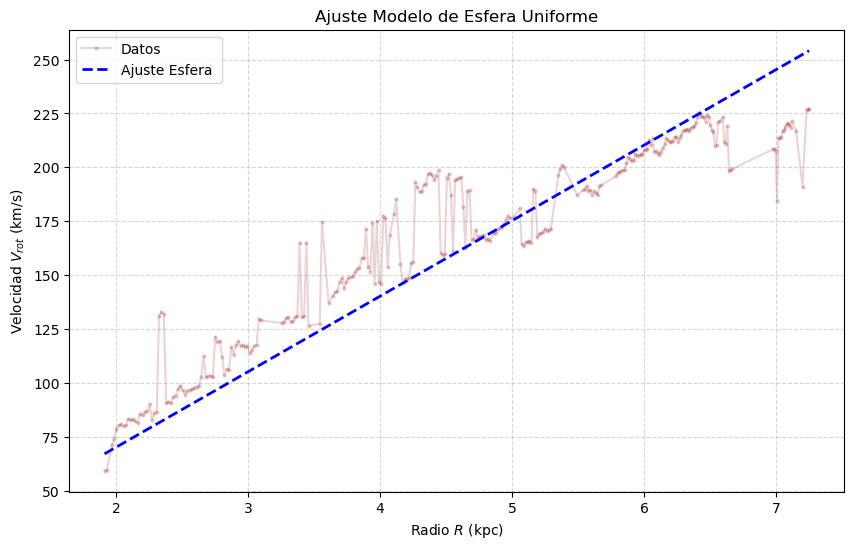

In [120]:
# Gráfico modelo esfera uniforme
def V_esfera_uniforme(R_kpc, rho):
    
    M = (4/3) * np.pi * R_kpc**3 * rho  # Masa dentro de radio R
    return np.sqrt(G * M / R_kpc)

# Gráfico
popt_e, _ = curve_fit(V_esfera_uniforme, R_datos, V_datos, p0=[1e7])
V_fit_e = V_esfera_uniforme(R_suave, *popt_e)
rho_fit_e = popt_e[0]


plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color='brown', alpha=0.2, label='Datos')
plt.plot(R_suave, V_fit_e, 'b--', linewidth=2, label=f'Ajuste Esfera ')
plt.title('Ajuste Modelo de Esfera Uniforme')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


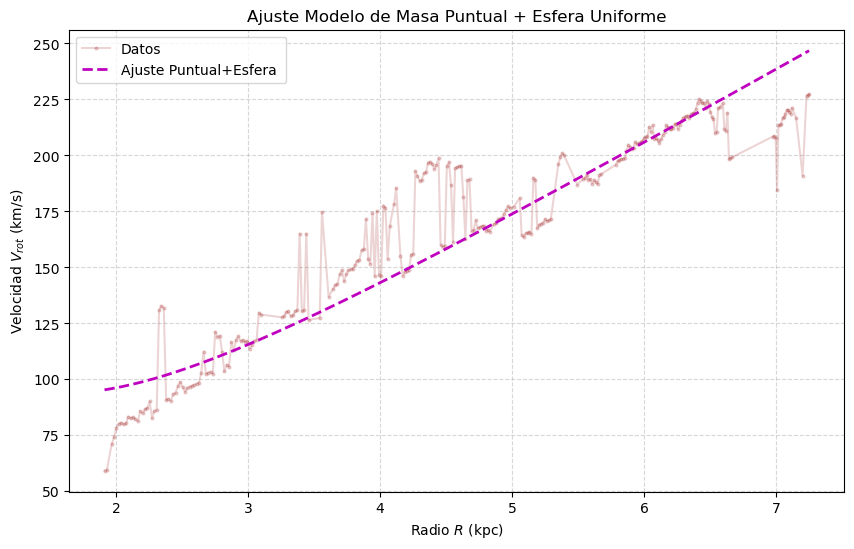

In [121]:
# Gráfico modelo masa puntual + esfera uniforme
def V_puntual_esfera(R_kpc, M0, rho):

    M_puntual = M0
    M_esfera = (4/3) * np.pi * R_kpc**3 * rho
    M_total = M_puntual + M_esfera
    return np.sqrt(G * M_total / R_kpc)

# Gráfico
popt_pe, _ = curve_fit(V_puntual_esfera, R_datos, V_datos, p0=[1e9, 1e6])
V_fit_pe = V_puntual_esfera(R_suave, *popt_pe)
M0_fit_pe, rho_fit_pe = popt_pe

plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color='brown', alpha=0.2, label='Datos')
plt.plot(R_suave, V_fit_pe, 'm--', linewidth=2, 
         label=f'Ajuste Puntual+Esfera ')
plt.title('Ajuste Modelo de Masa Puntual + Esfera Uniforme')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

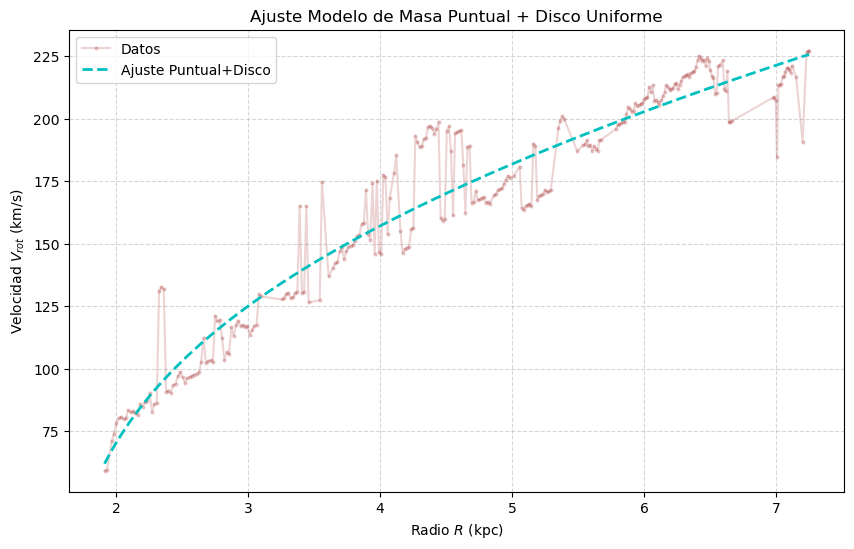

In [122]:
# Gráfico modelo masa puntual + disco uniforme
def V_puntual_disco(R_kpc, M0, S):
    
    M_puntual = M0
    M_disco = np.pi * R_kpc**2 * S
    M_total = M_puntual + M_disco
    return np.sqrt(G * M_total / R_kpc)

# Gráfico

popt_pd, _ = curve_fit(V_puntual_disco, R_datos, V_datos, p0=[1e9, 1e7])
V_fit_pd = V_puntual_disco(R_suave, *popt_pd)
M0_fit_pd, S_fit_pd = popt_pd

plt.figure(figsize=(10, 6))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color='brown', alpha=0.2, label='Datos')
plt.plot(R_suave, V_fit_pd, 'c--', linewidth=2, 
         label=f'Ajuste Puntual+Disco')
plt.title('Ajuste Modelo de Masa Puntual + Disco Uniforme')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

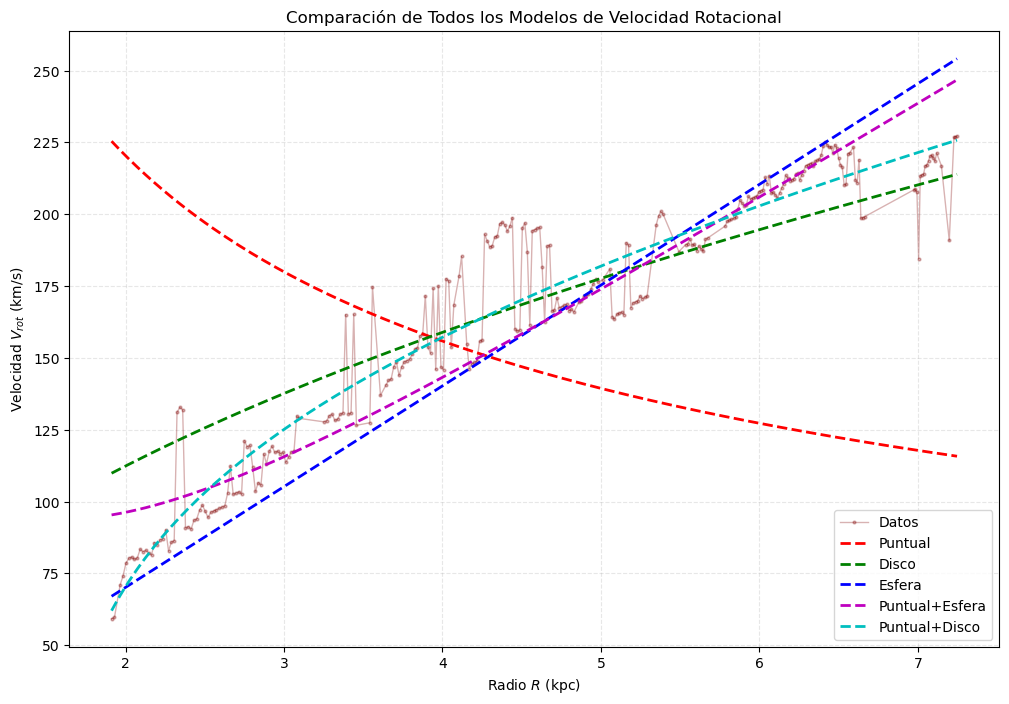

In [123]:
# Todos los modelos 
plt.figure(figsize=(12, 8))
plt.plot(R_datos, V_datos, 'o-', markersize=2, color= 'maroon', alpha=0.3, label='Datos', linewidth=1)

plt.plot(R_suave, V_fit_p, 'r--', linewidth=2, label=f'Puntual')
plt.plot(R_suave, V_fit_d, 'g--', linewidth=2, label=f'Disco')
plt.plot(R_suave, V_fit_e, 'b--', linewidth=2, label=f'Esfera')
plt.plot(R_suave, V_fit_pe, 'm--', linewidth=2, label=f'Puntual+Esfera')
plt.plot(R_suave, V_fit_pd, 'c--', linewidth=2, label=f'Puntual+Disco')

plt.title('Comparación de Todos los Modelos de Velocidad Rotacional')
plt.xlabel('Radio $R$ (kpc)')
plt.ylabel('Velocidad $V_{rot}$ (km/s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
